# Изучение архитектуры на основе LeNet в PyTorch. Осонвные операции сверточных нейронных сетей. 
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

https://huggingface.co/learn/computer-vision-course/
https://www.kaggle.com/learn/computer-vision
https://cs231n.github.io/
https://github.com/ahkarami/Great-Deep-Learning-Tutorials/blob/master/ComputerVision.md


## Импорт 

<!-- Как уже говорилось ранее модуль `torch.nn` содержит основные элементы для построения архитектур в рамках фреймворка `PyTorch`. 
Модуль предоставляет два типа API в классовом и процедурном стилях (подмодуль `torch.nn.functional`). В том числе модуль включает основные типы слоев нейронных сетей и основные функции активации и регуляризации.  -->

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [12]:
import torch.nn.functional as F
import torchvision
import torch
from torch import nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# LeNet архитектура

## Импорт torch

In [13]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [15]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [16]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)
g = torch.Generator(device = device)

torch version: 2.8
Using device: cuda
cuda:  cu128
Cuda is available: True
number of devices: 1
NVIDIA GeForce RTX 4060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 28


C:\Users\Ronkin\anaconda3\envs\py39\lib\site-packages\torch\__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


*Отметим, что от части данный урок вдохнавлен [этим](https://github.com/bentrevett/pytorch-image-classification) и [этим](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_convolutional-neural-networks/lenet.ipynb#scrollTo=FIGBGtQAyPIL) примерами.*

# Архитектура LeNet и ее модификации

В данном уроке мы рассмотрим методы описания архитектур нейронных сетей на примере архитектуры `LeNet`. Данная архитектура была одной из первых удачных попыток создания сверточных нейронных  сетей. Большенство подходов, использованных при создании архитектуры `LeNet` используются и сегодня, однако, не все. Поэтому мы реализуем адаптированный вариант `LeNet`.

Иллюстрация архитектуры `LeNet` представлена на рисунке ниже.

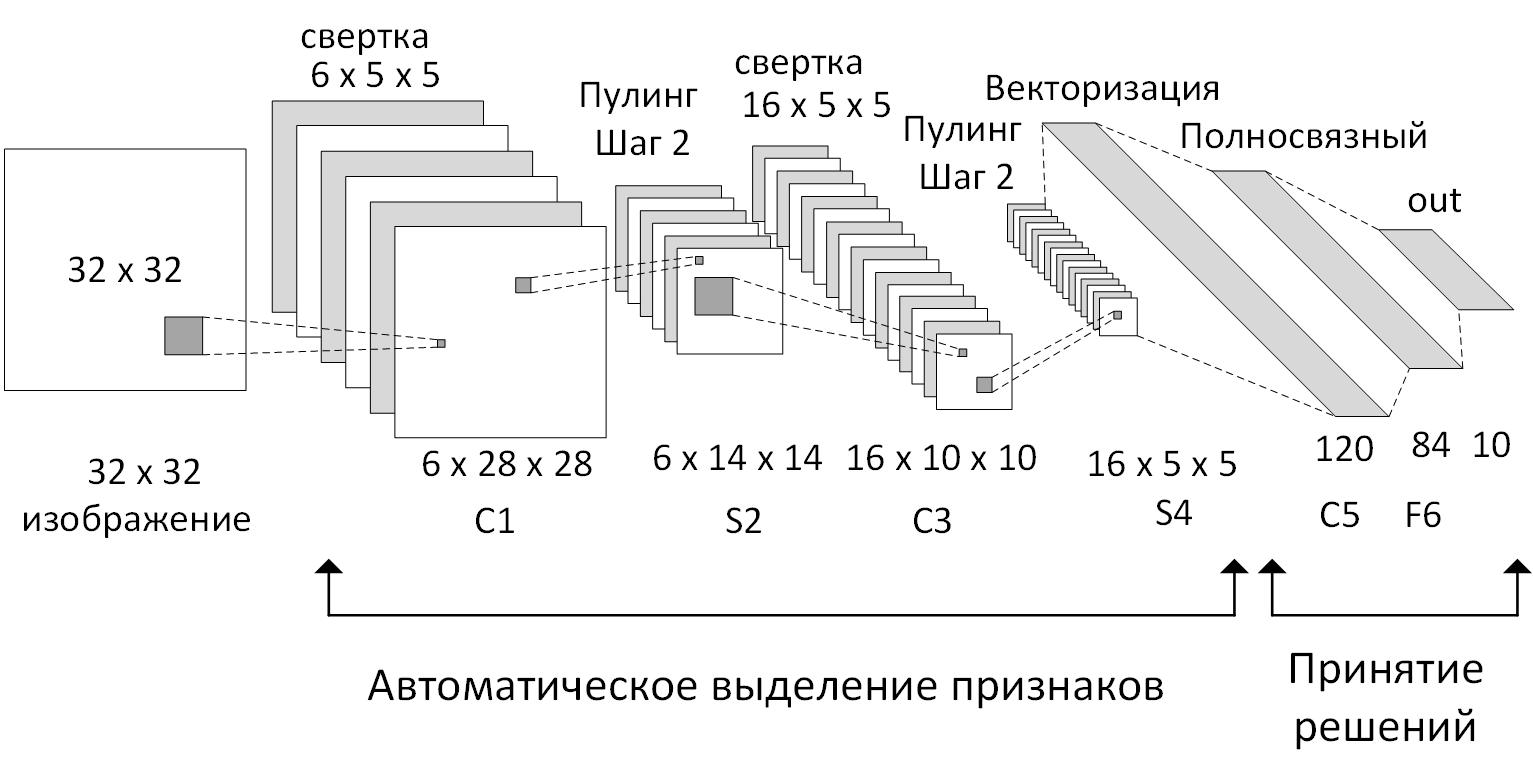
<!-- <img src="LeNet5.png" alt="LeNet5" title="LeNet5" width="650" />  -->

Для реализации архитектуры создадим класс, наследующий от `nn.Model`.

При описании архитектуры мы будем ориентироваться изображения размером $32\times 32$.

Каждый сверточный слой будет состоять из последовательности: *свертка*$\to$*активация*$\to$*пулинг*; каждый полносвязный слой будет состоять из *линейного слоя* и *активации*. Последний полносвязный слой должен иметь число выходов, равное числу классов. В нашем случае это будет $10$ классов. 

Сама архитектура сети должна быть описана в методе `forward`, который  должен иметь в качестве аргумента входной батч `x`. 

*Отметим*, что предпочтительно проводить инициализацию элементов архитектур нейронных сетей вне метода `forward`, в том числе в конструкторе класса `__init__`.



Таким образом архитектура `LeNet` имеет:
 * входной слой для изображений 32х32 (*число каналов*х32х32),
 * два сверточных слоя, 
 * каждый сверточный слой имеет также макс-пулинг субдискретизацию,
 * слой векторизации карты признаков (приобразования матрицы в вектор путем ее "разворачивания",
 * два полносвязных внутренних слоя,
 * выходной слой - слой классификации с 10 выходами.

Также особенности архитектуры:
* свертка валидная (с уменьшением размера карты признаков на размер ядра - 1)$^*$;
* ядро свертки имеет размер 5х5 (размер ядра = 5);
* макс-пулин выполняется с шагом 2 по тайлам 2х2;
* первый сверточный слой выдает 6 карт признаков 14х14 (после макс-пулинга);
* второй сверточный слой выдает 16 карт признаков 5х5 (после макс-пулинга);
* слой разворачивания принимает 16 карт признаков 5х5 и выдет вектор $1х16*5*5$ (1х400);
* первый полносвязный слой имеет 120 выходов (120 перцептронов);
* второй полносвязный слой имеет на выходе 84 перцептрона.

>$^*$Вобщем случае размер выхода свертки можно расчитать как: $$W=\frac{W−F+2P}{S}+1$$, где<ul>
    <li> $W$ входной размер, 
    <li> $F$ размер ядра свртки, 
    <li> $S$ шаг ядра,
    <li> $P$ паддинг. 

Реализуем сверточную сеть LeNet в виде класса

In [17]:
class LeNet(nn.Module):
    
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 5)
                                        

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        
        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2, 
                                 stride      = 2)
        
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5) 
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)        
        x = self.pool(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.tanh(x)        
        x = self.pool(x)

        #flatten
        x = self.flatten(x)
        
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x)
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

In [107]:
class LeNetModified(nn.Module):
    
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 3)

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 3)
        
        self.conv3   = nn.Conv2d(in_channels = 16, 
                                 out_channels = 32,
                                 kernel_size  = 3)   
        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2, 
                                 stride      = 2)
        
        # # classification
        # self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
        #                      out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 32 * 4 * 4, 
                             out_features = 32)
        
        self.fc_out = nn.Linear(in_features = 32, 
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 32 * 4 * 4) 
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x)        
        x = self.pool(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.tanh(x)        
        x = self.pool(x)
        
        #3-nd layer
        x = self.conv3(x)         
        x = torch.tanh(x)        
        # x = self.pool(x)

        #flatten
        x = self.flatten(x)
        
        # # 1-st fc layer
        # x = self.fc1(x)
        # x = torch.tanh(x)
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x)
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

Отметим, что в силу простоты модели в общем случае ее можно было бы реализовать в контейнере `nn.Sequential`,
```python
model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84), 
            nn.Tanh(),
            nn.Linear(84, 10)
            )
```
Однако,
в более сложных моделях подход `nn.Sequential` окажется не столь удобным.

In [108]:
model = LeNetModified(3,10)#LeNet(3,10)

# from torchinfo import summary
summary(model, input_size = (1,3,32,32)) #(1,3,32,32) - [B, C, H, W]

Layer (type:depth-idx)                   Output Shape              Param #
LeNetModified                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 30, 30]            168
├─AvgPool2d: 1-2                         [1, 6, 15, 15]            --
├─Conv2d: 1-3                            [1, 16, 13, 13]           880
├─AvgPool2d: 1-4                         [1, 16, 6, 6]             --
├─Conv2d: 1-5                            [1, 32, 4, 4]             4,640
├─Linear: 1-6                            [1, 32]                   16,416
├─Linear: 1-7                            [1, 10]                   330
Total params: 22,434
Trainable params: 22,434
Non-trainable params: 0
Total mult-adds (M): 0.39
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.09
Estimated Total Size (MB): 0.17

Посмотрим также карту параметров

In [109]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size()) 
    
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 3, 3])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 3, 3])
conv2.bias 	 torch.Size([16])
conv3.weight 	 torch.Size([32, 16, 3, 3])
conv3.bias 	 torch.Size([32])
fc2.weight 	 torch.Size([32, 512])
fc2.bias 	 torch.Size([32])
fc_out.weight 	 torch.Size([10, 32])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 22434
Number of all parameters for the model: 22434


Посмортим на выход сети в данный момент. 

In [110]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())


[[ 0.07154026 -0.0499741   0.19010168  0.14645956 -0.11925212 -0.08616089
  -0.11666743  0.1294967  -0.06646865 -0.06292965]] 
 max position (Class index): 2


## Dataset

В данном примере мы рассмотрим набор данных `CIFAR 10`.

`Cifar10` - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер `32` на `32` пикслея (то есть представляет тензор размером `3х32х32`).

Например `Cifar10` содержит следующие изображения.

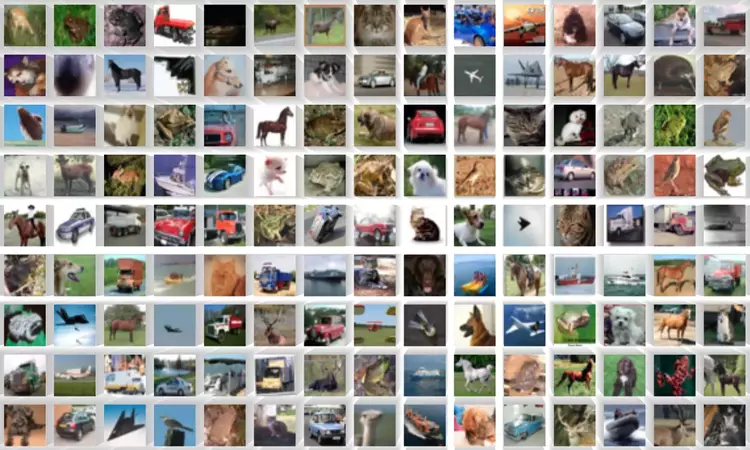


Опишим набор преобразований. Мы будем использовать разные преобразования дл тестового и тренировочного наборов данных. В преобразованиях мы используем стандартную нормализацию яркости изображений, о которой речь шла в одном из предыдущих занятий.

In [111]:
MEAN = torch.tensor([0.485, 0.456, 0.406]) 
STD  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.Resize(36),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

__Обратите внимание__, что часто рекомендуется после выполнения преобразований провести нормализацию `Normalize(mean, std)`. При этом заданные константы среднего и сдандартного отклонения определены эмпирически для достаточно крупных наборов данных.

Часто для трех-канальных (`RGB`) изображений рекомендуемые значения:
* $mean = [0.485, 0.456, 0.406]$ 
* $std = [0.229, 0.224, 0.225]$. 

Данные значения получены путем усреднения по набору данных `ImageNet2012`, разъяснение можно найти [тут](https://github.com/pytorch/vision/pull/1965) и [тут](https://github.com/pytorch/vision/issues/1439). 

* Для черно-белых изображений рекомендуемые значения $mean=[0.445]$ и $std=[0.2692]$.

Проведем загрузку набора данных. Для этого воспользуемся стандартным функционалом модуля `torchvision.datasets`. Загрузка будет происходить в два этапа: первый - тренеровочный набор данных, второй - тестовый. Для каждого набора данных задаим преобразования.

После загрузки наборов данных проверим какие классы в наборах представлены.

In [112]:
# !pip3 install --upgrade certifi

In [113]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [114]:

trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


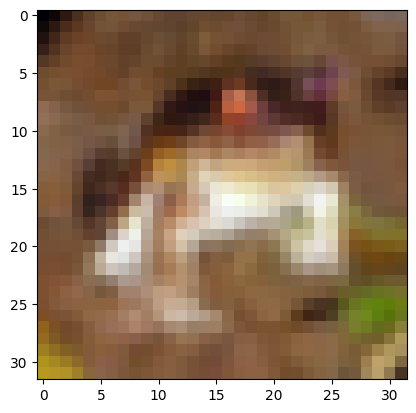

In [115]:
img = trainset[0][0].data.cpu().numpy().transpose((1,2,0))
img = (img - img.min())/(img.max() - img.min())
plt.imshow(img)

<blockquote>
    
Отметим, что также можно загрузить свой набор данных 
и также сделать свой класс для набора даннх вида 
```python
class CustomImageDataset(Dataset):
    def __init__(self,...):
        ...

    def __len__(self):
       ...

    def __getitem__(self, idx):
        ...
        return sample
```      
Также наборы данных могут быть загружены в некоторых стандатрных формах. Например, класс `ImageFolder` позволяет загружать набор данных в виде структуры: `директория датасата->(train, val, test)->директории по классам`. Подробную информацию можно найти в документации [тут](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) и в официальном примере [тут](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).
    
Доступные наборы посмотреть данных в модуле `torchvision.datasets` можно посмотреть при помощи команды `print(torchvision.datasets.__all__)`. Документация по данному модулю может быть найдена [тут](https://pytorch.org/vision/stable/datasets.html). 

Выделим часть тренировочного набора данных в валидационный. Для этого воспользуемся встроенным методом `random_split`. Если вы используете `GPU` метод потребует указать соответствующий генератор случайных чисел, например `torch.Generator(device='cuda')`.

In [116]:
VALID_RATIO = 0.7

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset,[n_train_examples, n_valid_examples], generator=g)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [117]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 35000
Number of validation examples: 15000
Number of testing examples: 10000


Сами по себе созданные объекты `trainset, validset` и `testset` являются экземплярами класса `torch.utils.data.dataset.Subset`, который описывает наборы данных. 

Для того, чтобы получить из соответствующего класса данные в формате загрузчика `PyTorch` можно воспользоваться классом `DataLoader` из `torch.utils.data`. Данный класс представляет загрузчик мини-батчей (пакетов) данных. Для его использования укажем размер батча, а также установим флаг перемешивания данных для тренировочной части.

Важно отметить, что экземпляры класса `DataLoader` - являются итерируемыми объектами. Работа с таким объектами может осуществляться только в цикле. Также, для единичного вызова итерируемых объектов можно воспользоваться конструкцией вида `next(iter(data))`.

In [118]:
BATCH_SIZE = 128

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, generator=g)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE)

В конструкторе класса `DataLoader` также важно отметить аргументы `num_workers`, `pin_memory` и `generator`. 
* Аргумент `num_workers` использует субпроцессы для асинхронной загрузки данных на `CPU`. Увеличение числа работников приводит к параллелизации загрузки и предобработки данных, однако слишьком большое число работников может привести к излишней загрузке памяти (ОЗУ) и даже может заторозить работу. Число работников по умолчанию 0 - это означает, что работа будет выполнена в главном процессе.
* Аргумент `pin_memory` позволяет  зарезервировать ОЗУ в `GPU` для ускорения операций загрузки в видеоускоритель.
* Аргумент генератор позволяет специфицировать метод выборки. В некоторых случаях, при использовании `GPU` рекомендуется использовать `generator=torch.Generator(device='cuda')`. Также отметим, что в тех же случаях не стоит одновременно задавать `generator`  и  `num_workers`.

Проверим работоспособность загручика данных

In [119]:
# get some random training images batch
dataiter = next(iter(trainloader))

# parse images and lables from batch
images, labels = dataiter

print(images.shape,labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


Обратите внимание на размерность данных, тут сначала идет размер выборки (число объектов в батче), затем число каналов (у нас 3 канала), а затем размер каждого объекта. Таким орбазом каждый батч является 4-х мерным. Это важно понимать для последующей обработки данных вне фреймворка `PyTorch`.

Теперь попробуем визуализировать набор данных. Для этого мы напишим функцию `imshow`. Аргументами данной функции являются: батч (`images`), число изорбажений по вертикали (`nrow`), размер изображения (`figsize`), а также значения среднего и СКО, использовавшиеся для визуализации изображений. Последние нужны для восстоновление нормализованного изображения. 

В данной функии мы выполняетм транспонирование (перестановку размерностей) для входонго бата. Это необходимо для того, чтобы привести размерности к стандартному виду для `matplotlib`. 

Также отметим, что для визуализации изображений мы должны преобразовать их из формата `torch.tensor` в `numpy.ndarray`. Если тензор находится на `GPU` мы также должны отправить его обратно на `CPU`. Для совершения этих операций мы воспользуемся стандартным методом:
`img = img.data.cpu().numpy()`.


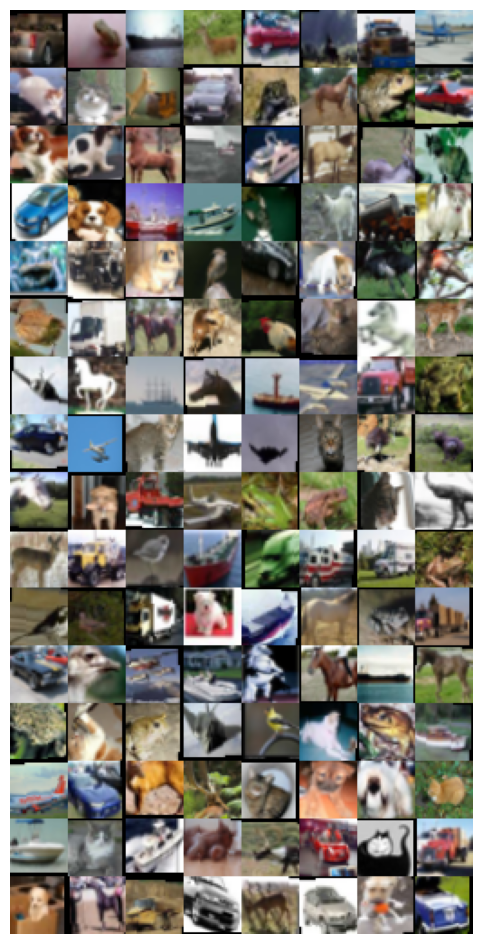

first raw classes automobile  frog  ship  deer automobile  deer truck airplane   cat   cat   cat automobile  frog horse  frog automobile
torch.Size([128, 3, 32, 32])


In [120]:
def imshow(images, nrow = 8,figsize=(16,12), mean=MEAN, std=STD):
    
    img = torchvision.utils.make_grid(images, nrow = nrow, padding = 0).to(device)

    img = img.transpose(2,0).transpose(0,1)

    std = torch.as_tensor(std).to(device)
    mean = torch.as_tensor(mean).to(device)
    img = (img * std + mean)# unnormalize 
    
    img = img.data.cpu().numpy()
       
    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Проведем инициализацию весовых параметров модели. Напомним, что для слоев с `ReLU` рекомендуется проводить инициализацию Кайменга Ге (`Kaiming He`) с нормальным распределением, а для слоев с сигмоидом инициализацию Хавьера Глора (`Xavier Glort`) с равномерным распределением. В нашем случа мы воспользуемся функцией `nn.init.kaiming_normal_`. Также проинциализируем смещения нулями для всех слоев.

In [121]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)
        
model.apply(initialize_parameters);


In [122]:
model.modules

<bound method Module.modules of LeNetModified(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc_out): Linear(in_features=32, out_features=10, bias=True)
)>

Для оценки точности работы модели зададим функцию `accuracy`, которая будет подсчитывать число паравильных ответов `correct_cls` и сравнивать с числом ответов всего.

In [123]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Теперь зададим параметры обучения. Мы будем использовать `CrossEntropyLoss` в качестве функции потерь и оптимизацию методом `SGD with momentum` c фиксированной скоростью обучения (`LR`) и моментом $0.9$ - данное значение, как правило, рекомендуется по умолчанию.



In [124]:
LR = 0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

Зададимся уже известными функциями `train` и `evaluate`

In [125]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()
 
    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [126]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Запишем вспомогательную функцию расчета времени.

In [127]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Проведем тренировку на 20 эпохах. В ходе проведения тренировки будем контролровать лучшую эпоху проверяя ее loss на валидации. Каждые 2 эпохи будем выводить результат работы сети в текстовом виде.

Отметим, что желающие могут найти более развернутые примеры решения задачи классификации в разделе `references` официального репозитория `torchvision` [тут](https://github.com/pytorch/vision/tree/v0.8.2/references/classification).

In [128]:
def fit(model, train_loader, val_loader, optimizer, 
        criterion, metric, epochs = EPOCHS, 
        device='cpu',  path_best = 'best_model.pt', verbose = True):
    
    best_valid_loss = float('inf')
    
    # Инициализация истории обучения
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'epoch_time': []
    }

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)
        
        # Сохранение метрик в историю
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        history['epoch_time'].append(epoch_mins * 60 + epoch_secs)  # сохраняем время в секундах

        if verbose == True:
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
            f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 
    
    return history

In [129]:
history = fit(model, trainloader, validloader, optimizer, criterion, metric, epochs = EPOCHS, device='cuda', verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 1.930 | Train Acc: 31.11%  | Val. Loss: 1.720 | Val. Acc: 39.07%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.758 | Train Acc: 36.93%  | Val. Loss: 1.602 | Val. Acc: 43.27%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.658 | Train Acc: 40.33%  | Val. Loss: 1.511 | Val. Acc: 46.39%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.598 | Train Acc: 42.29%  | Val. Loss: 1.486 | Val. Acc: 46.89%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.562 | Train Acc: 43.64%  | Val. Loss: 1.499 | Val. Acc: 47.18%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.534 | Train Acc: 44.71%  | Val. Loss: 1.400 | Val. Acc: 50.44%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.498 | Train Acc: 46.37%  | Val. Loss: 1.398 | Val. Acc: 49.96%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.475 | Train Acc: 46.77%  | Val. Loss: 1.395 | Val. Acc: 50.00%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 20s
	Train Loss: 1.464 | Train Acc: 47.36%  | Val. Loss: 1.350 | Val. Acc: 52.38%


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 1.453 | Train Acc: 47.79%  | Val. Loss: 1.351 | Val. Acc: 51.65%


Теперь попробуем визуализировать процесс обучения.

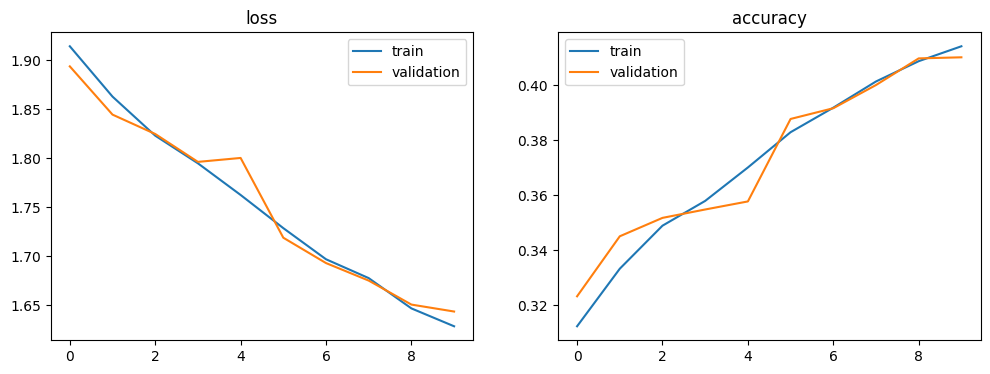

In [67]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss, label = 'train')
    axs[0].plot(valid_loss, label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc, label = 'train')
    axs[1].plot(valid_acc, label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(history['train_loss'], history['valid_loss'], 
            history['train_acc'], history['valid_acc'], )

Проверим точность на лучшей эпохе для тестового набора данных.

In [72]:
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print( f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.542 | Test Acc: 45.02%


<!-- <blockquote>
    
Отметим, что процесс обучения может также быть дополнен некоторыми другими опциами. Так, например, процесс может быть дополнен классичесими <code>L1</code> и/или <code>L2</code> регуляризациями. Для использования общей <code>L2</code> регуляризации достаточно использовать вариант `SGD with weight_dacy` в виде:
```python
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9,weight_decay=1e-4 )
```
 -->

Теперь посмотрим на результаты точности по каждому классу  для тестового набора данных. 

Отметим, что в данной операции мы отдельно подсчитываем точность как отношение `class_correct` к `class_total` по каждому классу `label`, а  также собираем  классы для всех экземпляров `labels` и предсказания `predicts`.

In [130]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():
    
    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')
        
        cls_pred = torch.argmax(y_pred, dim=1)
        
        c = (cls_pred == y).squeeze() # one-hot vector
        
        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1
    
        labels.append(y)
        predicts.append(cls_pred)
        
labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array
    
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of airplane : 61 %
Accuracy of automobile : 64 %
Accuracy of  bird : 27 %
Accuracy of   cat : 28 %
Accuracy of  deer : 35 %
Accuracy of   dog : 44 %
Accuracy of  frog : 65 %
Accuracy of horse : 67 %
Accuracy of  ship : 53 %
Accuracy of truck : 63 %


В ряде случаев, также будет важным сохраненить результатов работы сети. Для этого может быть использован, например следующий код.

In [131]:
sorted_ids = list(range(1, n_samples + 1)) 

sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': predicts})

df['label'] = df['label'].apply(lambda x: names_classes[x])

df.to_csv('submission.csv', index=False)

Также построим т.н. `confusion_matrix` - матрицу, изображающую результаты предсказаний для каждого класса.

In [132]:
def plot_confusion_matrix(labels, pred_labels, names_classes):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

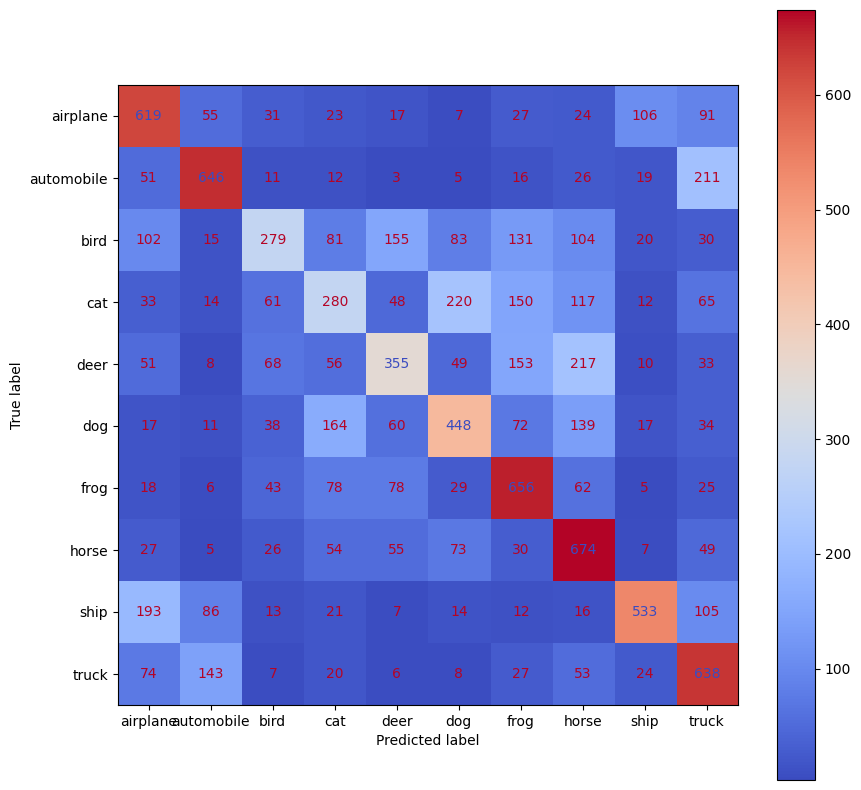

In [133]:
plot_confusion_matrix(labels, predicts, names_classes)

Отметим, также возможность для визуализации работы нейронной сети. Попробуем визуализировать карты признаков для фильтров первого слоя.

In [137]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    
    print(images.shape)
    
    filters = filters.cpu()

    n_images  = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)
    
    fig = plt.figure(figsize=(20, 20))

    for i in range(n_images):

        img = images[i].squeeze(0).numpy().transpose((1,2,0))
        
        img = 255*(img - img.min())/(img.max() - img.min())

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        
        ax.imshow(img.astype(int), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            
            image = image.numpy().astype(float)
            
            image = 255*(image - image.min())/(image.max() - image.min())
            
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            
            ax.imshow(image.astype(int), cmap='bwr')
            
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')
    return filtered_images

torch.Size([10, 3, 32, 32])


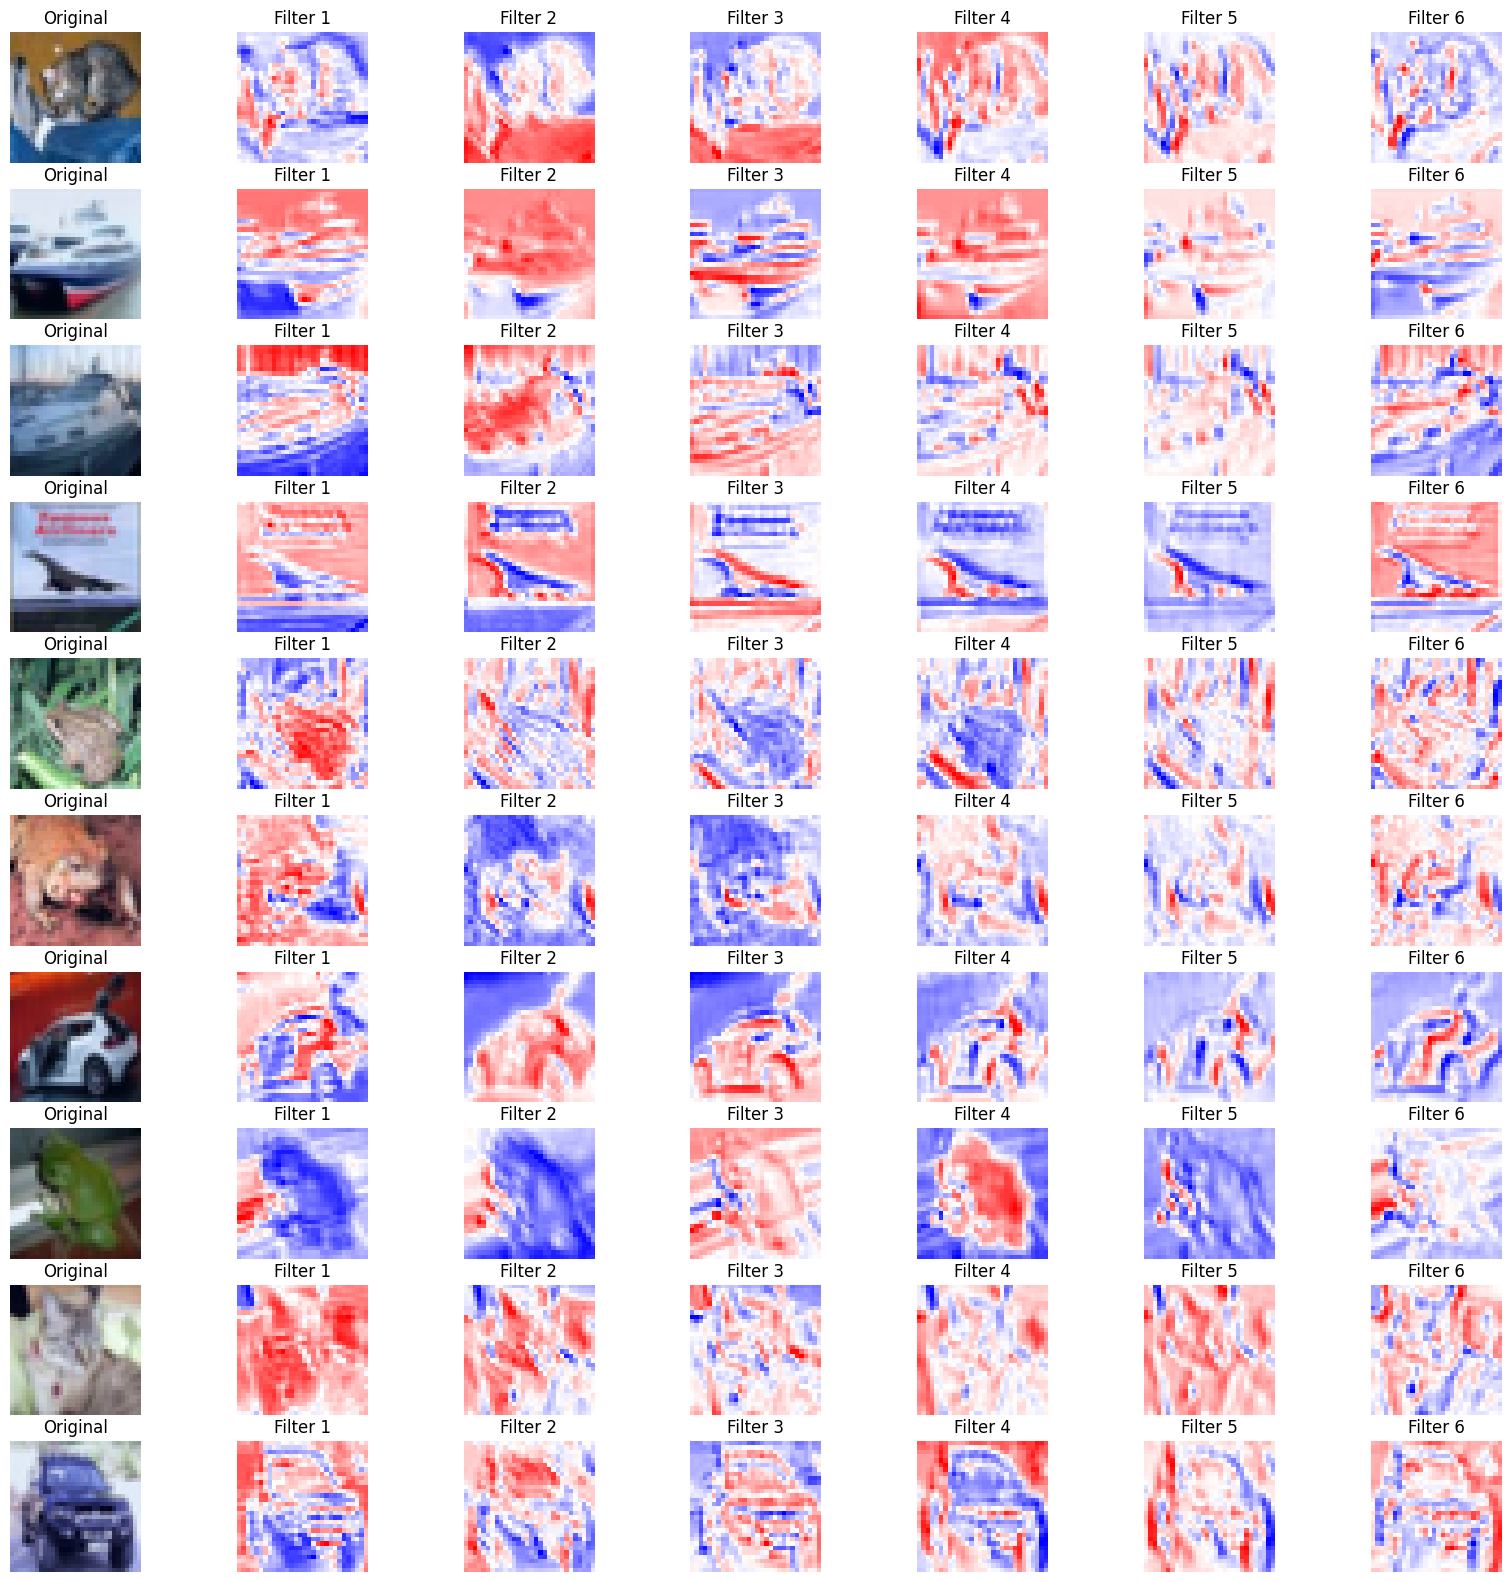

In [139]:
N_IMAGES = 10

images = [image for image, label in [testset[i] for i in range(N_IMAGES)]]

filters = model.conv1.weight.data

filtered_images = plot_filtered_images(images, filters)

## Задания

__1.__ Проверьте помогает ли для увеличения точности использование агументаци.

__2.__ Наиболее "тяжелые" слои  в сверточных нейронных сетях - это полносвязные слои принятия решений.  В оригинальной архитектуре их два. __Проверьте__ на сколько снижается точность и объем параметров, если убрать один полносвязный слой из архитектуры LeNet.

__3.__ В Оригинальной работы Лекуна использовался средний пулинг и функции активации вида $f(x)=tanh(x)+\alpha\cdot x$, где $\alpha<<1$ и оптимизатор `SGD with momentum`. Проверьте точность архитектуры если заменить средний пулинг на максимальный, если использовать определение точности по Лекуну. 

__4.__ В оригинальной работе Лекун использовал групповые свертки с числом групп $2$, каждая свертка была размером $5\times 5$, а каждый раз, когда число сверток в слое увеличивалось (*это каждый сверточный слой*), то производился пулинг размера изображений в два раза.  В более поздних архитектурах пришили к выводу, что лучше иметь больше слоев, но размер ядра $3\times 3$, пулинг для ускорения работы можно заменить на увеличенный шаг свертки, а регулирование числа групп позволяет более эффективно выделять признаки в изображении. __Предлагаем__ проверить указанные эффекты для архитекутры Ленет.